# Training Generative Adversarial Networks (GANs) in PyTorch

This tutorial is a hands-on beginner-friendly introduction to GANs which are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

The notebook was implemented by <i>Alaa Bessadok</i>, researcher at BASIRA lab, ITU.<br>

#### Table of contents

1. Prepare the training data
2. Implement the discriminator and the generator
3. Define losses, optimizers and helper functions for training
4. Train the models
5. Check the losses and samples generated by the GAN

<b>Resources:</b><br> 
https://jovian.ai/aakashns/06-mnist-gan*

After you complete this one you'll have a much better understanding of GANs!

So, let's start!

![picture](https://drive.google.com/uc?export=view&id=1qlslB9oioKlF0KOYlZRbmQLoDNM7vFi8)

# Prepare the training data

We begin by downloading and importing the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`. Images are usually in the [0., 1.] or [0, 255] range, Normalize transform will bring them into [-1, 1] range.
It's one of those things somebody figured out experimentally that it works (without special theoretical arguments).

*Reference: https://github.com/soumith/ganhacks*

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

C:\Users\user\anaconda3\envs\basic_concepts\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Label: 5


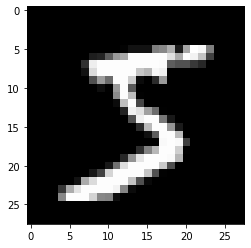

In [2]:
import matplotlib.pyplot as plt

img, label = mnist[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label)

Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Finally, let's create a dataloader to load the images in batches. 

Operating with large datasets requires loading them into memory all at once. In most cases, we face a memory outage due to the limited amount of memory available in the system. Also, the programs tend to run slowly due to heavy datasets loaded once. PyTorch offers a solution for parallelizing the data loading process with automatic batching by using DataLoader. Dataloader has been used to parallelize the data loading as this boosts up the speed and saves memory.

*Reference: https://www.geeksforgeeks.org/how-to-use-a-dataloader-in-pytorch/*


==> parameters: dataset from which to load the data, batch_size denoting how many samples per batch to load and shuffle which is set to True to have the data reshuffled at every epoch 

In [4]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 6, 3, 0, 4, 7, 9, 8, 5, 1, 6, 1, 8, 0, 0, 7, 9, 6, 6, 9, 7, 5, 1, 9,
        1, 1, 6, 8, 2, 2, 3, 4, 7, 7, 8, 7, 5, 3, 4, 9, 0, 2, 5, 1, 9, 4, 7, 0,
        9, 4, 3, 6, 1, 0, 5, 6, 8, 2, 5, 7, 1, 1, 8, 8, 6, 9, 1, 6, 7, 4, 2, 7,
        7, 1, 8, 4, 7, 2, 3, 5, 0, 5, 4, 4, 8, 1, 6, 5, 4, 9, 7, 5, 8, 8, 6, 2,
        7, 4, 1, 0])


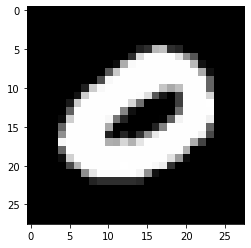

In [5]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

We'll also create a device which can be used to move the data and models to a GPU, if one is available.

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Implementing the discriminator and the generator
Let's define the generator and discriminator networks!





### Discriminator 
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. Specifically, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

We'll treat each 28x28 image as a vector of size 784.

In [7]:
image_size = 784
hidden_size = 256

The discriminator is a simple feedforward network with 3 linear layers. Note that we're using the Leaky ReLU activation for the discriminator. Reference: https://www.youtube.com/watch?v=Y-ruNSdpZ0Q



In ReLU, f(z) is zero when z is less than zero and f(z) is equal to z when z is above or equal to zero.But the issue is that all the negative values become zero immediately which decreases the ability of the model to fit or train from the data properly. That means any negative input given to the ReLU activation function turns the value into zero immediately in the graph, which in turns affects the resulting graph by not mapping the negative values appropriately. Reference: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

Leaky ReLU is an attempt to solve the dying ReLU problem. The leak helps to increase the range of the ReLU function. 

![picture](https://drive.google.com/uc?export=view&id=1VVRc6Z98YP6a_cunO7m1uHERgD6sCyHd)

In [8]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

Let's move the discriminator model to the chosen device.

In [9]:
D.to(device);

### Generator 

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. To further keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [10]:
latent_size = 64

In [11]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We use the TanH activation function for the output layer of the generator.

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." 

*Reference: https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh*

Let's move the generator to the chosen device.



In [12]:
G.to(device);

Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

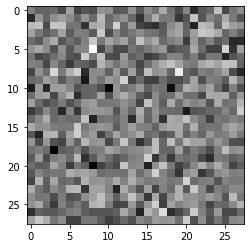

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

plt.imshow(gen_imgs[0], cmap='gray');


# Define losses, optimizers and helper functions for training



The binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task.

In [14]:
criterion = nn.BCELoss()

PyTorch implements various weight update rules for model training in torch.optim. We will use the Adam algorithm to train the discriminator and generator models. 

In [15]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

## Discriminator loss function

While the discriminator is trained, it classifies both the real data and the fake data from the generator. It penalizes itself for misclassifying a real instance as fake, or a fake instance (created by the  generator) as real, by maximizing the below function.

*Reference: https://neptune.ai/blog/gan-loss-functions*


![picture](https://drive.google.com/uc?export=view&id=1Y7XNJVPL14FurvZX8ghBTUSZgr8RPTt3)

Let's define helper functions to reset gradients and train the discriminator.

In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. Without reset function, the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

Note: we don't change the weights of the generator model while training the discriminator (d_optimizer only affects the D.parameters())

 *Reference: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch*

In [16]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    pred_labels_r = D(images)
    d_loss_real = criterion(pred_labels_r, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    pred_labels_f = D(fake_images)
    d_loss_fake = criterion(pred_labels_f, fake_labels)

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, pred_labels_r, pred_labels_f

With d_loss.backward() and d_optimizer.step() we calculate the gradients and update the generator weights. Remember that when we trained the generator, we kept the discriminator weights **frozen**.

In [17]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

## Generator loss function

While the generator is trained, it samples random noise and produces an output from that noise. The output then goes through the discriminator and gets classified as either “Real” or “Fake” based on the ability of the discriminator to tell one from the other.

The generator loss is then calculated from the discriminator’s classification – it gets rewarded if it successfully fools the discriminator, and gets penalized otherwise. 

*Reference: https://neptune.ai/blog/gan-loss-functions*

The following equation is minimized to training the generator:

![picture](https://drive.google.com/uc?export=view&id=15uITTAHWC2X03xO_W4SnLdqcjedGBPD1)

In [18]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)

    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Train the models

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.

In [19]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

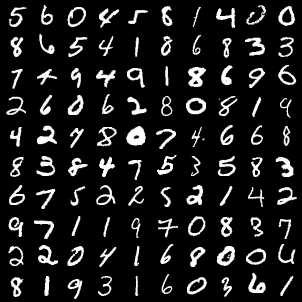

In [20]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


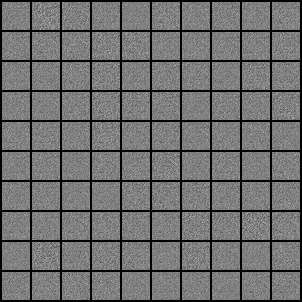

In [21]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [22]:
%%time

num_epochs = 200
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/2], Step [200/600], d_loss: 0.0614, g_loss: 3.8241, D(x): 0.99, D(G(z)): 0.05
Epoch [0/2], Step [400/600], d_loss: 0.0522, g_loss: 5.6813, D(x): 0.99, D(G(z)): 0.03
Epoch [0/2], Step [600/600], d_loss: 0.1273, g_loss: 4.6486, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/2], Step [200/600], d_loss: 0.0410, g_loss: 5.5990, D(x): 0.99, D(G(z)): 0.03
Epoch [1/2], Step [400/600], d_loss: 0.2016, g_loss: 5.2441, D(x): 0.98, D(G(z)): 0.16
Epoch [1/2], Step [600/600], d_loss: 0.2589, g_loss: 6.7575, D(x): 0.97, D(G(z)): 0.16
Saving fake_images-0002.png
Wall time: 44.5 s


# Check the samples generated by the GAN

Here's how the generated images look, after the 10th, 50th and 300th epochs of training.

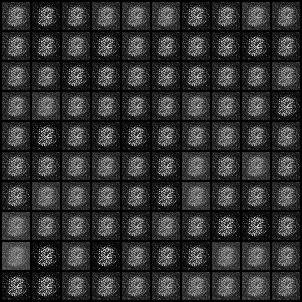

In [27]:
Image('./samples/fake_images-0300.png')


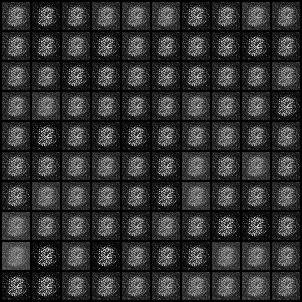

In [28]:
Image('./samples/fake_images-0300.png')


We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

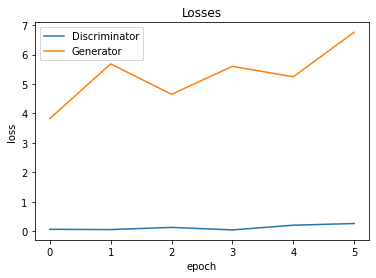

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

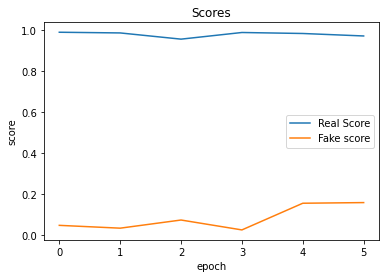

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');